In [1]:
# Imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import register_matplotlib_converters
import os 
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
np.random.seed(0)

In [2]:
from google.colab import drive
drive.mount('/content/drive')
filepath = "drive/My Drive/Documents/Education/University - 1 - UVA/Coursework - 6 - 2020 Fall/CS 4774 Machine Learning/ML4VA Project/ml4va"

Mounted at /content/drive


In [3]:
# Import data
df0 = pd.read_csv(filepath + "/Virginia_Crashes.csv")
df0.head()

,X,Y,OBJECTID,Document_Nbr,Crash_Dt,Time_Slicing,Weather_Condition,Rte_Nm,Rns_Mp,First_Harmful_Event_of_Entire_C,Speed_Notspeed,Belted_Unbelted,Alcohol_Notalcohol,Rd_Type,Collision_Type,Vehicle_Body_Type_Cd,Driver_Action_Type_Cd,Crash_Severity,K_People,A_People,B_People,C_People,LATITUDE,LONGITUDE,VSP,SYSTEM,OWNERSHIP,CRASH_YEAR,Local_Case_Cd,FAC,FUN,Light_Condition,DIAGRAM,VDOT_District,Node_Info,Ownership_Used,Physical_Juris,Plan_District,Carspeedlimit,Crash_Military_Tm,Crash_Event_Type_Dsc,Rte_Category_Cd,Roadway_Surface_Cond,Vehiclenumber,Driverage,Drivergen,Driverinjurytype,Passage,Pedage,Pedgen,Pedinjurytype,Passgen,Passinjurytype
0,-76.699480,36.827038,1,130015005,2013/01/02 00:00:00+00,6PM TO 9PM,1. No Adverse Condition (Clear/Cloudy),R-VA046SC00606EB,3.840718,14. Ditch,Not_SPEED,BELTED,Not_ALCOHOL,RD-UNKNOWN,9. Fixed Object - Off Road,1. Passenger car,40. Fail to Maintain Proper Control,B.Visible Injury,0,0,1,0,36.827030,-76.699478,5,3,3,2013,201202934,"0.Two-way, non-divided",6.Rural Local,4. Darkness - Road Lighted,http://rns/APP/Images/CrashDiagramProxy.aspx?d...,5.Hampton Roads,393039.Deer Path Trl; SC-606E (Isle of Wight C...,VDOT_SEC,46.Isle of Wight,23.Hampton Roads,NaN,2007,14. Ditch,SEC,1. Dry,1,18,Female,B,NaN,NaN,NaN,NaN,NaN,NaN
1,-77.663366,37.609240,2,130015012,2013/01/02 00:00:00+00,0AM TO 3AM,1. No Adverse Condition (Clear/Cloudy),R-VA SR00288NB,28.361159,23. Animal,Not_SPEED,BELTED,Not_ALCOHOL,NOT-RD,10. Deer,22. Truck - Sport Utility Vehicle (SUV),1. No Improper Action,C.Nonvisible Injury,0,0,0,1,37.609232,-77.663364,1,2,2,2013,DIV113000009,"3.Divided, full control of access",7.Rural Principal Arterial - Other Freeways an...,5. Darkness - Road Not Lighted,http://rns/APP/Images/CrashDiagramProxy.aspx?d...,4.Richmond,NaN,VDOT_PRI,37.Goochland,15.Richmond Regional,65.0,45,23. Animal,STPRI,1. Dry,1,50,Female,C,NaN,NaN,NaN,NaN,NaN,NaN
2,-79.067566,37.499473,3,130015020,2013/01/02 00:00:00+00,0AM TO 3AM,1. No Adverse Condition (Clear/Cloudy),R-VA US00029NB,83.336520,23. Animal,Not_SPEED,BELTED,Not_ALCOHOL,NOT-RD,10. Deer,2. Truck - Pick-up/Passenger Truck,1. No Improper Action,PDO.Property Damage Only,0,0,0,0,37.499465,-79.067563,3,2,2,2013,2013-000014,"3.Divided, full control of access",B.Urban Freeways and Expressways; Connecting L...,5. Darkness - Road Not Lighted,http://rns/APP/Images/CrashDiagramProxy.aspx?d...,3.Lynchburg,125036.US-29S;Ramp Intersection,VDOT_PRI,5.Amherst,11.Region 2000 Regional,70.0,148,23. Animal,USPRI,1. Dry,1,35,Male,PDO,NaN,NaN,NaN,NaN,NaN,NaN
3,-78.845314,38.453040,4,130015021,2013/01/02 00:00:00+00,3AM TO 6AM,1. No Adverse Condition (Clear/Cloudy),R-VA115UR04110EB,1.501908,4. Fence Or Post,Not_SPEED,BELTED,Not_ALCOHOL,RD-UNKNOWN,9. Fixed Object - Off Road,1. Passenger car,40. Fail to Maintain Proper Control,PDO.Property Damage Only,0,0,0,0,38.453032,-78.845311,2,9,6,2013,2013-000073,"0.Two-way, non-divided",I.Urban Collector,5. Darkness - Road Not Lighted,http://rns/APP/Images/CrashDiagramProxy.aspx?d...,8.Staunton,587178.Blue Ridge Dr; UR-4110E (City of Harris...,SEC_URBAN,115.Harrisonburg,6.Central Shenandoah,NaN,427,4. Fence Or Post,URB,1. Dry,1,24,Male,PDO,NaN,NaN,NaN,NaN,NaN,NaN
4,-77.084017,38.885604,5,130015041,2013/01/02 00:00:00+00,6AM TO 9AM,1. No Adverse Condition (Clear/Cloudy),R-VA US00050EB,84.790921,11. Jersey Wall,Not_SPEED,BELTED,ALCOHOL,NOT-RD,9. Fixed Object - Off Road,1. Passenger car,40. Fail to Maintain Proper Control,PDO.Property Damage Only,0,0,0,0,38.885596,-77.084014,7,2,2,2013,130101-026,"3.Divided, full control of access",E.Urban Other Principal Arterials; Connecting ...,4. Darkness - Road Lighted,http://rns/APP/Images/CrashDiagramProxy.aspx?d...,9.Northern Virginia,100218.10th St N; US-50E;VA-237E,VDOT_PRI,0.Arlington,8.Northern Virginia,45.0,617,11. Jersey Wall,USPRI,1. Dry,1,29,Female,PDO,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df0.shape

(939248, 53)

In [5]:
# Drop redundant columns
df = df0.drop(["OBJECTID", "Document_Nbr", "Rte_Nm", "Local_Case_Cd", "DIAGRAM", "Node_Info", "X", "Y"], axis = 1)

# Filter the dataset to only contain crashes from the past two years
indices = np.where(np.logical_or(df["CRASH_YEAR"] == 2019, df["CRASH_YEAR"] == 2020))[0]
df_filt = df.iloc[indices, :].reset_index(drop = True)

variables = {
        "ordinal" : ["Time_Slicing", "Speed_Notspeed", "Belted_Unbelted", "Alcohol_Notalcohol"],
        "nominal" : ["Weather_Condition", "Collision_Type", "FAC", "Ownership_Used", "Roadway_Surface_Cond"],
        "numerical": ["Rns_Mp", "VSP", "SYSTEM", "OWNERSHIP", "Carspeedlimit", "Crash_Military_Tm"],
        "target": ["Crash_Severity"]
        }

In [6]:
# Split into X and Y
X = df_filt[variables["ordinal"] + variables["nominal"] + variables["numerical"]]
Y = df_filt["Crash_Severity"]

# Do a stratified train/test split
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 0)
for train_index, test_index in split.split(df_filt, df_filt["Crash_Severity"]):
    df_train = df.loc[train_index]
    df_test = df.loc[test_index]

# Separate training and test dataframes into their respective feature matrices and target vectors
X_train = df_train.loc[:, np.not_equal(df_train.columns, "Crash_Severity")]
Y_train = df_train["Crash_Severity"]
X_test = df_test.loc[:, np.not_equal(df_train.columns, "Crash_Severity")]
Y_test = df_test["Crash_Severity"]

In [7]:
# Reset index
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
Y_train = Y_train.reset_index(drop = True)
Y_test = Y_test.reset_index(drop = True)

In [8]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(147060, 44)
(147060,)
(36765, 44)
(36765,)


In [9]:
pd.Series(Y_train).value_counts().sort_values(ascending = False) / Y_train.size

PDO.Property Damage Only    0.643866
B.Visible Injury            0.186747
C.Nonvisible Injury         0.108316
A.Severe Injury             0.055474
K.Fatal Injury              0.005596
Name: Crash_Severity, dtype: float64

In [10]:
pd.Series(Y_test).value_counts().sort_values(ascending = False) / Y_test.size

PDO.Property Damage Only    0.642867
B.Visible Injury            0.188440
C.Nonvisible Injury         0.109180
A.Severe Injury             0.054264
K.Fatal Injury              0.005250
Name: Crash_Severity, dtype: float64

In [11]:
# Split into ordinal and numerical sets
X_train_ordinal = X_train[variables["ordinal"]]
X_train_numerical = X_train[variables["numerical"]]
X_test_ordinal = X_test[variables["ordinal"]]
X_test_numerical = X_test[variables["numerical"]]

In [12]:
# Remove any rows with missing values for nominal features
X_train_nominal = X_train[variables["nominal"]]
X_train_nominal_missing = np.array(X_train_nominal.isna()).any(axis = 1)
X_train_nominal_missing_indices = np.where(X_train_nominal_missing)[0]
X_train.drop(X_train_nominal_missing_indices, inplace = True)
X_train_ordinal.drop(X_train_nominal_missing_indices, inplace = True)
X_train_numerical.drop(X_train_nominal_missing_indices, inplace = True)
X_train_nominal.drop(X_train_nominal_missing_indices, inplace = True)
Y_train.drop(X_train_nominal_missing_indices, inplace = True)

X_test_nominal = X_test[variables["nominal"]]
X_test_nominal_missing = np.array(X_test_nominal.isna()).any(axis = 1)
X_test_nominal_missing_indices = np.where(X_test_nominal_missing)[0]

X_test.drop(X_test_nominal_missing_indices, inplace = True)
X_test_ordinal.drop(X_test_nominal_missing_indices, inplace = True)
X_test_numerical.drop(X_test_nominal_missing_indices, inplace = True)
X_test_nominal.drop(X_test_nominal_missing_indices, inplace = True)
Y_test.drop(X_test_nominal_missing_indices, inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [13]:
# Ordinal encoding 
X_train_ordinal_tr = OrdinalEncoder().fit_transform(X_train_ordinal)
X_test_ordinal_tr = OrdinalEncoder().fit_transform(X_test_ordinal)

In [14]:
# One-hot encoding
enc2 = OneHotEncoder(drop = "first")
X_train_nominal_tr = enc2.fit_transform(X_train_nominal).toarray()
X_test_nominal_tr = enc2.transform(X_test_nominal).toarray()

In [15]:
# Numerical processing
X_train_numerical = SimpleImputer(strategy = "median").fit_transform(X_train_numerical)
X_test_numerical = SimpleImputer(strategy = "median").fit_transform(X_test_numerical)
sc = StandardScaler()
X_train_numerical_tr = sc.fit_transform(X_train_numerical)
X_test_numerical_tr = sc.transform(X_test_numerical)

In [16]:
# Label encoding
Y_train_tr = LabelEncoder().fit_transform(Y_train)
Y_test_tr = LabelEncoder().fit_transform(Y_test)

In [17]:
# Concatenate all of the X arrays
X_train_numerical_tr = pd.DataFrame(X_train_numerical_tr)
X_train_ordinal_tr = pd.DataFrame(X_train_ordinal_tr)
X_train_nominal_tr = pd.DataFrame(X_train_nominal_tr)
X_train_tr = pd.concat((X_train_numerical_tr, X_train_ordinal_tr, X_train_nominal_tr), axis = 1)

X_test_numerical_tr = pd.DataFrame(X_test_numerical_tr)
X_test_ordinal_tr = pd.DataFrame(X_test_ordinal_tr)
X_test_nominal_tr = pd.DataFrame(X_test_nominal_tr)
X_test_tr = pd.concat((X_test_numerical_tr, X_test_ordinal_tr, X_test_nominal_tr), axis = 1)

In [18]:
print(X_train_tr.shape)
print(Y_train_tr.shape)
print(X_test_tr.shape)
print(Y_test_tr.shape)

(131736, 62)
(131736,)
(32983, 62)
(32983,)


In [19]:
pd.Series(Y_train_tr).value_counts().sort_values(ascending = False) / Y_train_tr.size

4    0.639613
1    0.190138
2    0.107108
0    0.057236
3    0.005906
dtype: float64

In [20]:
pd.Series(Y_test_tr).value_counts().sort_values(ascending = False) / Y_test_tr.size

4    0.638571
1    0.191917
2    0.108389
0    0.055574
3    0.005548
dtype: float64

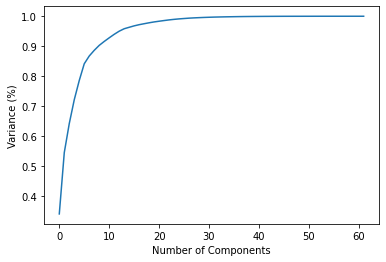

In [21]:
# Visualize PCA for various numbers of principal components
pca = PCA()
pca.fit(X_train_tr)
pca_variances = np.cumsum(pca.explained_variance_ratio_)
plt.figure()
plt.plot(pca_variances)
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') # for each component
plt.show()

In [22]:
# Apply PCA to the data
n_pc = np.where(pca_variances >= 0.99)[0][0] + 1
pca = PCA(n_components = n_pc).fit(X_train_tr)
X_train_pca = pca.transform(X_train_tr)
X_test_pca = pca.transform(X_test_tr)

In [23]:
print(X_train_pca.shape)
print(Y_train_tr.shape)
print(X_test_pca.shape)
print(Y_test_tr.shape)

(131736, 25)
(131736,)
(32983, 25)
(32983,)


In [24]:
# Number of classes
n_classes = np.unique(Y_train_tr).size
n_classes

5

In [25]:
model = KNeighborsClassifier()
model.fit(X_train_pca, Y_train_tr)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [26]:
# Make predictions
Y_train_pred = model.predict(X_train_pca)
Y_test_pred = model.predict(X_test_pca)

In [27]:
print(Y_train_pred.shape)
print(Y_train_pred)

(131736,)
[4 2 1 ... 4 4 4]


In [28]:
print(Y_test_pred.shape)
print(Y_test_pred)

(32983,)
[4 4 4 ... 4 4 1]


In [29]:
# Calculate metrics for training set
acc_train = accuracy_score(Y_train_tr, Y_train_pred)
prec_train = precision_score(Y_train_tr, Y_train_pred, average = None)
recall_train = recall_score(Y_train_tr, Y_train_pred, average = None)
f1_train = f1_score(Y_train_tr, Y_train_pred, average = None)

# Calculate metrics for testing set
acc_test = accuracy_score(Y_test_tr, Y_test_pred)
prec_test = precision_score(Y_test_tr, Y_test_pred, average = None)
recall_test = recall_score(Y_test_tr, Y_test_pred, average = None)
f1_test = f1_score(Y_test_tr, Y_test_pred, average = None)

In [30]:
# Create dataframe
metrics_train = np.array([acc_train, \
                          prec_train[0], prec_train[1], prec_train[2], prec_train[3], prec_train[4], \
                          recall_train[0], recall_train[1], recall_train[2], recall_train[3], recall_train[4], \
                          f1_train[0], f1_train[1], f1_train[2], f1_train[3], f1_train[4]])

metrics_test = np.array([acc_test, \
                         prec_test[0], prec_test[1], prec_test[2], prec_test[3], prec_test[4], \
                         recall_test[0], recall_test[1], recall_test[2], recall_test[3], recall_test[4], \
                         f1_test[0], f1_test[1], f1_test[2], f1_test[3], f1_test[4]])

metrics = {"Training Set": metrics_train, "Testing Set": metrics_test}
metrics = pd.DataFrame(metrics)
metrics.index = ["Accuracy", \
                 "Precision (Class 0)", "Precision (Class 1)", "Precision (Class 2)", "Precision (Class 3)", "Precision (Class 4)", \
                 "Recall (Class 0)", "Recall (Class 1)", "Recall (Class 2)", "Recall (Class 3)", "Recall (Class 4)", \
                 "F1 Score (Class 0)", "F1 Score (Class 1)", "F1 Score (Class 2)", "F1 Score (Class 3)", "F1 Score (Class 4)"]

In [31]:
# Display metrics
metrics

,Training Set,Testing Set
Accuracy,0.688164,0.558075
Precision (Class 0),0.479715,0.180363
Precision (Class 1),0.512229,0.236730
Precision (Class 2),0.499946,0.232143
Precision (Class 3),0.512195,0.111111
Precision (Class 4),0.748490,0.664874
Recall (Class 0),0.268170,0.092199
Recall (Class 1),0.387137,0.176145
Recall (Class 2),0.331042,0.156364
Recall (Class 3),0.053985,0.010929
